Set Working Directory

In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/964505/CT/ct_research/v2'

Packages

In [2]:
import yaml
import numpy as np

import src.experiments.file_io as file_io
import src.experiments.aggregate_average as core
import src.experiments.shared as shared
import src.viz.aggregate_average as viz

from pathlib import Path
from datetime import datetime

from src.utils.reproducibility import set_global_seed
from src.utils.metadata import get_git_commit_hash
from src.utils.config_loading import load_yaml_config

Functions

In [3]:
def compute_score_pair_errors(gt_score_pairs, pred_score_pairs):
    # calculate mean absolute error
    mean_error = np.mean(np.abs(gt_score_pairs - pred_score_pairs))

    # calculate ground truth std
    ground_truth_std = np.std(gt_score_pairs, ddof=1)
    
    return mean_error, ground_truth_std

In [4]:
def evaluate_error_by_missing_count(test_x, test_y, test_predictions, dims=14):
    _, cur_score = core.split_encoding_and_scores(test_x, dims=dims)
    future_score_gt = test_y

    mean_errors_list = []
    ground_truth_std_list = []
    ground_truth_dict = {}
    missing_counts = list(range(0, dims))

    for n in missing_counts:
        filter_mask = core.filter_sessions_by_missing_count(cur_score, n)
        filtered_gt = future_score_gt[filter_mask]
        filtered_pred = test_predictions[filter_mask]

        ground_truth_dict[str(n)] = filtered_gt

        if filtered_gt.size == 0:
            mean_errors_list.append(np.nan)
            ground_truth_std_list.append(np.nan)
            continue

        mean_error, std_dev = compute_score_pair_errors(filtered_gt, filtered_pred)
        mean_errors_list.append(mean_error)
        ground_truth_std_list.append(std_dev)

    return missing_counts, mean_errors_list, ground_truth_std_list, ground_truth_dict

Script

In [5]:
config_path = "config/experiments/20250624_aggavg_1.yaml"

In [6]:
# load configuration
config = load_yaml_config(config_path)
run_type = config["settings"]["type"] # repeat vs non-repeat
device = config["settings"]["device"] # cpu or cuda
seed = config["settings"]["seed"]

data_source = config["data"]["data_source"] # npz file with multiple arrays
model_source = config["data"]["model_source"] # path to the model
output_destination = config["data"]["destination_base"]

In [7]:
## general setup
figure_names = ["accuracy_assessment.png", "aggregate_average.png"]


## set global seed
set_global_seed(seed)

## get git commit hash
git_commit_hash = get_git_commit_hash()

In [8]:
## load model
model = shared.load_model(model_source, device=device)

In [9]:
## read data
test_data = np.load("old_data/next_step_test_data_encoded.npy")
test_data = core.filter_rows_by_sum(test_data, slice(0, 14), 1)
from src.training.training_torch import split_input_target

test_x, test_y = split_input_target(test_data)
test_predictions = shared.inference(model, test_x)
test_x = test_x.cpu().numpy()
test_y = test_y.cpu().numpy()

In [10]:
test_x.shape, test_y.shape, test_predictions.shape

((960116, 42), (960116, 14), (960116, 14))

In [11]:
## filter by session type
repeat_mask = core.assign_repeat(test_x)

encoidngs: [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
score_pairs: [[[0.526      0.47399998]
  [0.02       0.98      ]
  [0.148      0.852     ]
  ...
  [0.127      0.873     ]
  [0.081      0.919     ]
  [1.         0.        ]]

 [[0.526      0.47399998]
  [0.11       0.89      ]
  [1.         0.        ]
  ...
  [0.364      0.63600004]
  [0.644      0.356     ]
  [0.2        0.8       ]]

 [[1.         0.        ]
  [1.         0.        ]
  [1.         0.        ]
  ...
  [0.74       0.26      ]
  [1.         0.        ]
  [0.         0.        ]]

 ...

 [[0.831      0.16900003]
  [0.79       0.20999998]
  [0.333      0.667     ]
  ...
  [1.         0.        ]
  [0.243      0.75699997]
  [0.         0.        ]]

 [[1.         1.        ]
  [1.         1.        ]
  [0.         0.        ]
  ...
  [1.         1.        ]
  [1.         1.        ]
  [0.089      0.911   

In [12]:
repeat_mask.sum()

np.int64(956635)

In [13]:
# if run type is repeat, filter for only repeat sessions
# if run type is non-repeat, filter for only non-repeat sessions
if run_type == "repeat":
    test_x = test_x[repeat_mask]
    test_y = test_y[repeat_mask]
    test_predictions = test_predictions[repeat_mask]
elif run_type == "non-repeat":
    test_x = test_x[~repeat_mask]
    test_y = test_y[~repeat_mask]
    test_predictions = test_predictions[~repeat_mask]

In [14]:
test_x.shape, test_y.shape, test_predictions.shape

((956635, 42), (956635, 14), (956635, 14))

(1) find ground truth std and prediction MAE

In [15]:
encoding, cur_score = core.split_encoding_and_scores(test_x, dims=14)
future_score_gt = test_y

mean_errors_list = []
ground_truth_std_list = []
ground_truth_dict = {}
missing_counts = list(range(0, 14))

In [ ]:
def filter_target_scores(scores, mask):
    return scores[mask]

In [ ]:
for n in missing_counts:
    filter_mask = core.filter_sessions_by_missing_count(cur_score, n)
    filtered_encoding = encoding[filter_mask]
    filtered_gt = future_score_gt[filter_mask][filtered_encoding == 1]
    filtered_pred = test_predictions[filter_mask][filtered_encoding == 1]

    ground_truth_dict[str(n)] = filtered_gt

    if filtered_gt.size == 0:
        mean_errors_list.append(np.nan)
        ground_truth_std_list.append(np.nan)
        continue

    mean_error, std_dev = core.compute_errors(filtered_gt, filtered_pred)
    mean_errors_list.append(mean_error)
    ground_truth_std_list.append(std_dev)

Missing count: 0, Filtered sessions: 287259
Error:  [0.0265224  0.00453085 0.01405674 0.02137053 0.04338043]
Mean error: 0.026774095371365547, Ground truth std: 0.27786117792129517
Missing count: 1, Filtered sessions: 213585
Error:  [0.05821663 0.00101447 0.0365001  0.00303726 0.02897394]
Mean error: 0.026360534131526947, Ground truth std: 0.2737821042537689
Missing count: 2, Filtered sessions: 142808
Error:  [0.01897442 0.00881934 0.06706345 0.01246332 0.01011223]
Mean error: 0.027204066514968872, Ground truth std: 0.268984854221344
Missing count: 3, Filtered sessions: 101158
Error:  [0.01628518 0.04109797 0.07906926 0.01974225 0.0133357 ]
Mean error: 0.027373746037483215, Ground truth std: 0.2591855823993683
Missing count: 4, Filtered sessions: 78571
Error:  [0.00039792 0.00639565 0.01421417 0.00750223 0.09090641]
Mean error: 0.02792111411690712, Ground truth std: 0.2591993510723114
Missing count: 5, Filtered sessions: 53932
Error:  [0.04986393 0.03560287 0.00231993 0.00860023 0.0753

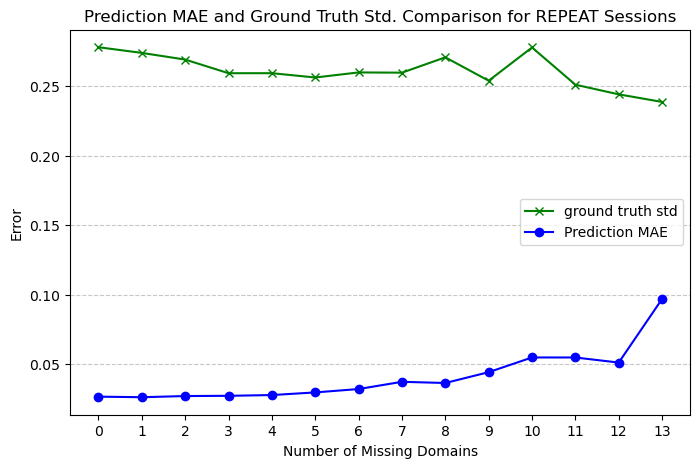

In [28]:
# plot error by missing count and save figure
viz.plot_error_by_missing_count(
    missing_counts=missing_counts,
    std=ground_truth_std_list,
    error=mean_errors_list,
    run_type=run_type
)

(2) predict scores based on strategy

In [29]:
# ground truth original scores
_, scores_gt = core.split_encoding_and_scores(test_x, dims=14)

In [30]:
# ground truth future scores
future_scores_gt = test_predictions

In [31]:
scores_gt.shape, future_score_gt.shape

((956635, 28), (956635, 14))

In [32]:
# best
prediction_list = []
rows, cols = test_y.shape
_, scores = core.split_encoding_and_scores(test_x, dims=14)
for domain in range(14):
    print("============= domain %d" % (domain + 1))
    encoding = core.create_single_encoding(rows, cols, domain)
    print("encoding: ", encoding)
    tmp_single = core.add_encoding(scores, encoding)
    print("data put in model", tmp_single)
    single_prediction = shared.inference(model, tmp_single)
    print("prediction: ", single_prediction)
    prediction_list.append(single_prediction[:, domain])

prediction_matrix = np.column_stack(prediction_list)
difference = prediction_matrix - scores[:, ::2]

# find max indices
max_values, max_indices = shared.max_prediction_from_difference(difference, prediction_matrix, scores)
# reconstruct matrices
future_scores_best, best_encoding = core.reconstruct_max_matrices(max_values, max_indices, prediction_matrix.shape)


============= domain 1
encoding:  [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
data put in model tensor([[1.0000, 0.0000, 0.0000,  ..., 0.9190, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.3560, 0.2000, 0.8000],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.0000, 0.0000, 0.0000,  ..., 0.7570, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0890, 0.9110],
        [1.0000, 0.0000, 0.0000,  ..., 0.6810, 0.9870, 0.0130]])
prediction:  [[ 5.2031422e-01 -1.2150735e-02  2.5378298e-03 ... -1.6408041e-03
  -3.8042609e-03  1.2432907e-02]
 [ 5.3318685e-01  2.9696822e-03  7.1362052e-03 ... -1.1826903e-03
  -2.1750717e-03 -2.7329102e-04]
 [ 9.7878426e-01  8.7643415e-03  3.4796651e-03 ... -1.2176044e-02
   1.3801077e-02  3.7907399e-03]
 ...
 [ 8.5447842e-01 -1.4362365e-02  2.7268557e-03 ...  1.8881731e-02
   9.7842943e-03  8.8515319e-04]
 [ 3.2938012e-01

In [33]:
future_scores_best.shape, best_encoding.shape

((956635, 14), (956635, 14))

In [34]:
# random
future_scores_random = core.find_random_predictions(
    model=model,
    data=test_x,
    run_type=run_type
)

In [35]:
future_scores_random.shape

(956635, 14)

In [36]:
average_gt_list = []
average_best_list = []
average_random_list = []

std_gt_list = []
std_best_list = []
std_random_list = []

In [37]:
for n in missing_counts:
    missing_mask = core.filter_sessions_by_missing_count(scores_gt, n)
    
    scores_gt_tmp = scores_gt[missing_mask][:, ::2]

    future_scores_gt_tmp = future_scores_gt[missing_mask]
    future_scores_best_tmp = future_scores_best[missing_mask]
    future_scores_random_tmp = future_scores_random[missing_mask]

    difference_gt = future_scores_gt_tmp - scores_gt_tmp
    difference_best = future_scores_best_tmp - scores_gt_tmp
    difference_random = future_scores_random_tmp - scores_gt_tmp

    average_gt = np.mean(np.abs(difference_gt))
    average_best = np.mean(np.abs(difference_best))
    average_random = np.mean(np.abs(difference_random))

    std_gt = np.std(difference_gt)
    std_best = np.std(difference_best)
    std_random = np.std(difference_random)

    average_gt_list.append(average_gt)
    average_best_list.append(average_best)
    average_random_list.append(average_random)

    std_gt_list.append(std_gt)
    std_best_list.append(std_best)
    std_random_list.append(std_random)

In [38]:
import matplotlib.pyplot as plt

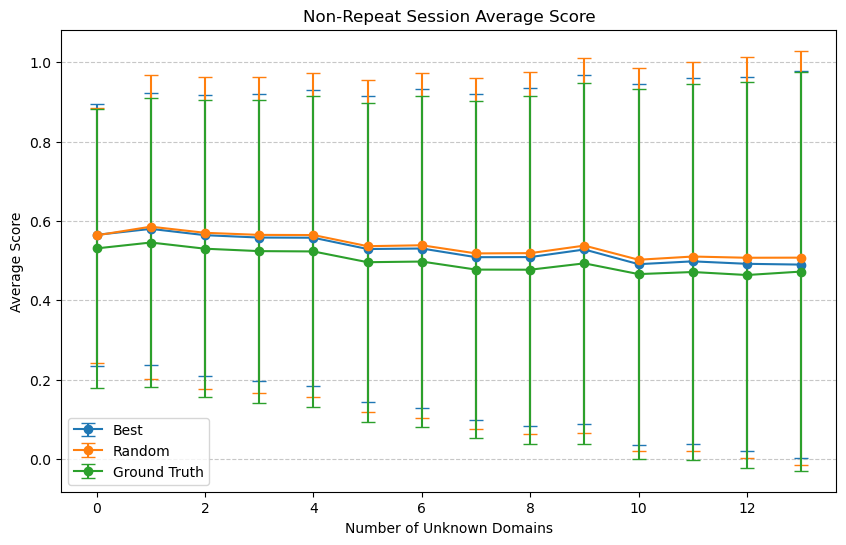

In [39]:
# Define x-axis values (number of unknown domains)
# Plot with error bars
plt.figure(figsize=(10, 6))

plt.errorbar(missing_counts, average_best_list, yerr=std_best_list, label="Best", fmt='-o', capsize=5)
plt.errorbar(missing_counts, average_random_list, yerr=std_random_list, label="Random", fmt='-o', capsize=5)
plt.errorbar(missing_counts, average_gt_list, yerr=std_gt_list, label="Ground Truth", fmt='-o', capsize=5)

# Labels and Title
plt.xlabel("Number of Unknown Domains")
plt.ylabel("Average Score")
plt.title("Non-Repeat Session Average Score")

# Legend and Grid
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [40]:
'''# get score pairs
gt_score_pairs = core.extract_score_pairs(gt_score_pairs)
pred_score_pairs = core.extract_score_pairs(pred_score_pairs)

# find valid score pairs
valid_mask = core.find_missing_mask(gt_score_pairs[:, :, 0], gt_score_pairs[:, :, 1])

# filter valid score pairs
gt_score_pairs = gt_score_pairs[valid_mask]
pred_score_pairs = pred_score_pairs[valid_mask]'''



'# get score pairs\ngt_score_pairs = core.extract_score_pairs(gt_score_pairs)\npred_score_pairs = core.extract_score_pairs(pred_score_pairs)\n\n# find valid score pairs\nvalid_mask = core.find_missing_mask(gt_score_pairs[:, :, 0], gt_score_pairs[:, :, 1])\n\n# filter valid score pairs\ngt_score_pairs = gt_score_pairs[valid_mask]\npred_score_pairs = pred_score_pairs[valid_mask]'